# Compare - Shanghai Composite Index

1. PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023
2. NOTE (of stock data):
    1. **Raw Data** is mostly non-stationary.
    2. **Returns Data** is stationary and also called differenced.

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts, build_downloaded_stock_uts
from time_series import TimeSeriesFactory
from data_plotter import InterpolatePlotter
from ts_models_no_retrain import AR_Model, MA_Model, ARMA_Model, ARIMA_Model, EvaluationMetric

## Stock Data: Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data

## Stock Data: Models

11. Split Returns Data
12. Initialize Models: `AR(p)` and `ARMA(p, q)`
13. Split Raw Data
14. Initialize Model: `ARMA(p, d, q)`

## Stock Data: Evaluation Metrics + Plots

15. Evaluation Metrics `MSE`, `RMSE`
16. Plot Actual Predictions vs Model Predictions

## Follow-up

- Notes on above

## Stock Data: Analysis

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-04", "2020-02-07"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index"),
    # ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
# # frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-01-16', '2020-01-17', '2020-01-20', '2020-01-21',
               '2020-01-22', '2020-01-23', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06'],
              dtype='datetime64[ns]', name='Date', length=2447, freq=None)


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

Len [2447]
Len [2447]
DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-01-16', '2020-01-17', '2020-01-20', '2020-01-21',
               '2020-01-22', '2020-01-23', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06'],
              dtype='datetime64[ns]', name='Date', length=2447, freq=None)


In [4]:
stock_symbol = '000001.SS'
stock_of_interest = stocks[stock_symbol]
type(stock_of_interest), stock_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_df = stock_of_interest.get_as_df()
stock_df

,Close
Date,
2010-01-04,3243.760010
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
...,...
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086


### Plot Raw Data

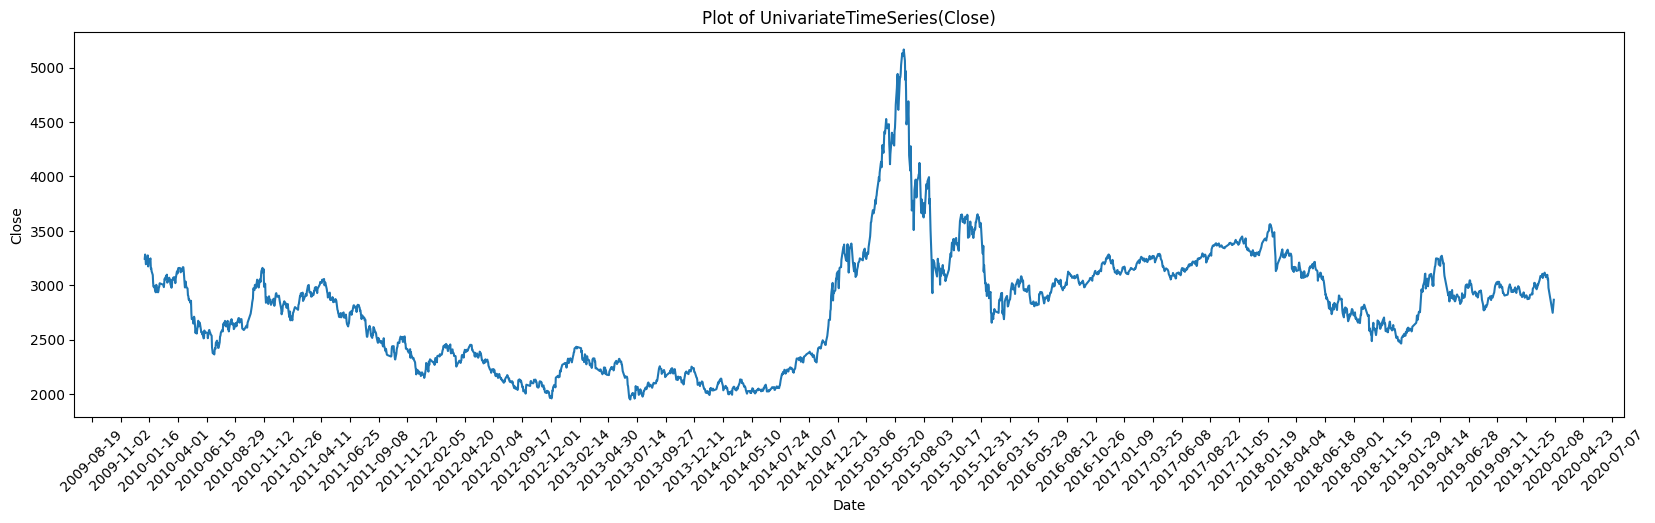

In [6]:
stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [8]:
stock_of_interest.get_statistics(time_type="Days", stock_data=True)

/Users/detraviousjamaribrinkley/Documents/Development/self/applied_time_series_and_machine_learning/framework_for_time_series_data/nlp_ts/../tslearn/time_series.py:195: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count_value = int(stats.loc['count'])


,Close
total Days,2447.0
most recent date,2015-06-12 00:00:00
inception date,2013-06-27 00:00:00
lowest price,1950.01
highest price,5166.35
average price,2801.36
range,3216.34
price volatility,529.3
25th percentile price,2346.35
median price,2859.76


In [ ]:
stock_of_interest.range_skewness_kurtosis()

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [ ]:
stock_of_interest.stationarity_test(stock_df)

### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.

In [ ]:
stock_of_interest.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this with traditional TS models like `AR`, `ARMA`.

In [ ]:
stock_of_interest.plot_partial_autocorrelation(35)

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Get Returns Data

- This should provide us with stationary data that we can pass to both `AR` and `ARMA` models.

In [ ]:
len(stock_of_interest.get_series()), stock_of_interest.get_series()

In [ ]:
stock_returns = stock_of_interest.data_augment_for_returns()
stock_returns

### Plot Returns

In [ ]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant variance although there are a few wide spread mean values between ~2014-10-07 to 2016-05-29 and ~2017-08-22 to 2019-04-14.

In [ ]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

### Get Descriptive Statistics of Returns Data

In [ ]:
stock_returns.get_statistics()

In [ ]:
stock_returns.range_skewness_kurtosis()

### Check Stationarity of Returns Data

- Data is now stationary. Confirm with independence test which is only conducted on returns and has a null-hypothesis of data being independent (or not dependent).

In [ ]:
stock_returns.stationarity_test(stock_returns_df)

In [ ]:
stock_returns.independence_test(stock_returns_df)

### Plot Autocorrelation and Partial Autocorrelation of Returns Data

In [ ]:
stock_returns.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is stationary as in the current value doesn't depend on the previous value. This is what we want for `MA(q)`.
    - Lag exponentially decays at 1, thus use lag 1 for `MA(q)` as they have in the PAPER.


In [ ]:
stock_returns.plot_partial_autocorrelation(50)

- What is the above telling us?
    - TS is stationary. The 1st is not dependent upon the 0th. This is what we want for `AR(p)`.
    - Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

## Stock Data: Models

### Split Differenced Data for `AR(p)`, `MA(q)`, `ARMA(p, q)` Models

- Make 5-day forecasts

In [ ]:
stock_returns.get_as_df()

In [ ]:
# interpolation_step = 5
# interpolation_step = 120
N = len(stock_returns.get_series())
interpolation_step = N - int(N * .8)
diff_train_length = N - interpolation_step

print(f"IS: {interpolation_step}\nTrain {diff_train_length}")

In [ ]:
# interpolation_step = 1956
# # interpolation_step = 60
# N = len(stock_returns.get_series())
# diff_train_length = N - interpolation_step
# diff_train_length

In [ ]:
diff_train_uts, diff_test_uts = stock_returns.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

In [ ]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

In [ ]:
diff_train_values = diff_train_uts.get_series()
diff_train_values

- Make 5-day forecasts, hence why test data is only 5 values.

In [ ]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

In [ ]:
diff_test_values = diff_test_uts.get_series()
len(diff_test_values)

In [ ]:
scatter_type = False
data_prediction_plots = InterpolatePlotter()
data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type)

#### Initialize Model: `AR(p)`

- Pass `diff_test_values` series instead of `diff_train_df` to drop index of the returned prediction

In [ ]:
lag_p = 1 # AR

In [ ]:
no_retrain_name = ' - no retrain'
no_retrain_bool = False

ar_no_retrain_model_class = AR_Model(no_retrain_name, lag_p)
ar_no_retrain_model_class.train(diff_train_values)
ar_no_retrain_model_class.summary()

In [ ]:
# retrain false
ar_predictions_no_retrain = ar_no_retrain_model_class.make_predictions(diff_train_values, diff_test_values)
ar_predictions_no_retrain
all_predictions_df = ar_no_retrain_model_class.model_predictions_to_df(diff_test_df, ar_predictions_no_retrain)
all_predictions_df

In [ ]:
predictions_df = all_predictions_df.iloc[:, 1]
# predictions_df

In [ ]:
data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, predictions_df)

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)

#### Initialize Model: `MA(q)`

In [ ]:
no_retrain_name

In [ ]:
error_q = 1 # MA
ma_model_class = MA_Model(no_retrain_name, error_q=error_q)
ma_model_class.train(diff_train_df.values)
ma_model_class.summary()

In [ ]:
ma_predictions_no_retrain = ma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = ma_model_class.model_predictions_to_df(diff_test_df, ma_predictions_no_retrain)
all_predictions_df

In [ ]:
ma_predictions_df = all_predictions_df.iloc[:, 2]
ma_predictions_df

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, ma_predictions_df)

#### Initialize Model: `ARMA(p, q)`

In [ ]:
arma_model_class = ARMA_Model(no_retrain_name, lag_p, error_q)
arma_model_class.train(diff_train_df.values)
arma_model_class.summary()

NOTE: Should Dep. Variable be t as t depends on t - 1?

In [ ]:
# retrain false
arma_predictions_no_retrain = arma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = arma_model_class.model_predictions_to_df(diff_test_df, arma_predictions_no_retrain)
all_predictions_df

In [ ]:
arma_predictions_df = all_predictions_df.iloc[:, 3]
arma_predictions_df

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, arma_predictions_df)

### Split Raw Data for `ARIMA(p, d, q)` Model

- Make 5-day forecasts

In [ ]:
# interpolation_step = 5
# interpolation_step = 60
# N = len(stock_of_interest.get_series())
# train_length = N - interpolation_step
# train_length

N = len(stock_of_interest.get_series())
interpolation_step = N - int(N * .8)
train_length = N - interpolation_step

print(f"IS: {interpolation_step}\nTrain {diff_train_length}")

In [ ]:
train_uts, test_uts = stock_of_interest.get_slice(start=1, end=train_length, both_train_test=True)
train_uts, test_uts

In [ ]:
train_df = train_uts.get_as_df()
test_df = test_uts.get_as_df()
train_df.plot(), test_df.plot()

In [ ]:
train_values = train_uts.get_series()
test_values = test_uts.get_series()
len(train_values), len(test_values)

In [ ]:
arima_plotter = InterpolatePlotter()
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, True)
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, False)

#### Initialize Models: `ARIMA(p, d, q)`

In [ ]:
diff_d = 1

arima_model_class = ARIMA_Model(no_retrain_name, lag_p, error_q, diff_d)
trained_arima_model = arima_model_class.train(train_values)
# trained_arima_model.summary()

In [ ]:
arima_predictions = arima_model_class.make_predictions(diff_train_values, diff_test_values)
all_raw_predictions_df = arima_model_class.model_predictions_to_df(test_df, arima_predictions)
all_raw_predictions_df

In [ ]:
arima_predictions_df = all_raw_predictions_df.iloc[:, 1]
len(arima_predictions_df), arima_predictions_df.head(3)

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)

arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, scatter_type=False, predictions_df=arima_predictions_df)

In [ ]:


# EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
# EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

# arima_predictions_dict = {
#     'ARIMA No Retrain': arima_predictions_no_retrain,
# }
# scatter_plot = False
# prediction_plots = InterpolatePlotter(test_df, arima_predictions_dict)
# prediction_plots.plot_in_sample_predictions(scatter_plot)

# arima_predictions_dict = {
#     'ARIMA Retrain': arima_predictions_retrain,
# }
# scatter_plot = False
# prediction_plots = InterpolatePlotter(test_df, arima_predictions_dict)
# prediction_plots.plot_in_sample_predictions(scatter_plot)

## Stock Data: Evaluation Metrics + Plots

### Evaluation Metrics: MSE, RMSE

In [ ]:
# AR
EvaluationMetric.eval_mse(diff_test_df, ar_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, ar_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_retrain, per_element=False)

# ARMA
EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

# ARIMA
EvaluationMetric.eval_mse(test_df, arima_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(test_df, arima_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

### Plots Actual Predictions vs Model Predictions
- Need to finish plots

In [ ]:
# predictions_dict = {
#     'AR No Retrain': ar_predictions_no_retrain,
#     'AR Retrain': ar_predictions_retrain,
#     'ARMA No Retrain': arma_predictions_no_retrain,
#     'ARMA Retrain': arma_predictions_retrain,
#     'ARIMA No Retrain': arima_predictions_no_retrain,
#     'ARIMA Retrain': arima_predictions_retrain
# }

In [ ]:
ar_predictions_dict = {
    'AR No Retrain': ar_predictions_no_retrain,
    'AR Retrain': ar_predictions_retrain,
    # 'ARMA Retrain': arma_predictions_retrain
}
scatter_plot = False
prediction_plots = InterpolatePlotter(diff_test_df, ar_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

In [ ]:
# 'ARMA No Retrain': arma_predictions_no_retrain,
arma_predictions_dict = {

    'ARMA Retrain': arma_predictions_retrain,
}
prediction_plots = InterpolatePlotter(diff_test_df, arma_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

arma_predictions_dict = {

    'ARIMA Retrain': arima_predictions_retrain
}
prediction_plots = InterpolatePlotter(diff_test_df, arma_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

arma_predictions_dict = {

    'ARMA No Retrain': arma_predictions_no_retrain,
}
prediction_plots = InterpolatePlotter(diff_test_df, arma_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

arima_predictions_dict = {

    'ARIMA No Retrain': arima_predictions_no_retrain,
}
prediction_plots = InterpolatePlotter(diff_test_df, arima_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

In [ ]:
arima_predictions_no_retrain

## Follow-up